# Численные методы: Модель определения рыночной стоимости автомобиля

### Описание проекта

Сервис по продаже автомобилей разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости авто. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание данных

**Признаки**


        DateCrawled — дата скачивания анкеты из базы
        VehicleType — тип автомобильного кузова
        RegistrationYear — год регистрации автомобиля
        Gearbox — тип коробки передач
        Power — мощность (л. с.)
        Model — модель автомобиля
        Kilometer — пробег (км)
        RegistrationMonth — месяц регистрации автомобиля
        FuelType — тип топлива
        Brand — марка автомобиля
        NotRepaired — была машина в ремонте или нет
        DateCreated — дата создания анкеты
        NumberOfPictures — количество фотографий автомобиля
        PostalCode — почтовый индекс владельца анкеты (пользователя)
        LastSeen — дата последней активности пользователя

**Целевой признак**

    Price — цена (евро)

## План по выполнению проекта
1. Загрузим и подготовим данные.
2. Обучим несколько моделей с различными гиперпараметрами.
3. Проанализируем скорость работы и качество моделей.
Критерий качества RMSE (Root Mean Square Error - Квадратный корень среднеквардатичной ошибки​).

# 1. Подготовка данных

### Импортируем необходимые библиотеки для работы

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

Импортируем данные из файла и выведем их на экран

In [ ]:
df = pd.read_csv('file.csv')

In [ ]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Выведем информацию о датасете

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Выведем на экран суммы пропусков в данных

In [ ]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**Вывод**

Дадасет имеет 354369 строк и 16 признаков. Имеются пропуски в данных: 
- VehicleType          37490
- Gearbox              19833
- Model                19705
- FuelType             32895
- NotRepaired          71154

Все пропуски относятся с типу данных - объект.

Проверим качество моделей с удалением пропусков и без удаления пропусков.

In [ ]:
df = df.dropna()

При удалении пропусков модели показали лучше качество (* Изначально мы обучили модели без удаления пропусков).

Проверим корректность удаления пропусков в данных.

In [ ]:
df.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Выявим дубликаты в строках данных.


In [ ]:
df.duplicated().sum()

4

Мы нашли 4 дубликата, удалим их. Проверим результат удаления дубликатов.

In [ ]:
df = df.drop_duplicates().reset_index(drop = True)

In [ ]:
df.duplicated().sum()

0

## Подготовим признаки

Удалим признаки, которые не влияют на цену автомобиля:

- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [ ]:
df = df.drop(['DateCrawled', 
              'RegistrationMonth', 
              'DateCreated', 
              'NumberOfPictures', 
              'PostalCode', 
              'LastSeen'], axis=1)

Выведем на экран информацию о датасете после удаления признаков которые не влияют на цену автомобиля.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245810 entries, 0 to 245809
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             245810 non-null  int64 
 1   VehicleType       245810 non-null  object
 2   RegistrationYear  245810 non-null  int64 
 3   Gearbox           245810 non-null  object
 4   Power             245810 non-null  int64 
 5   Model             245810 non-null  object
 6   Kilometer         245810 non-null  int64 
 7   FuelType          245810 non-null  object
 8   Brand             245810 non-null  object
 9   NotRepaired       245810 non-null  object
dtypes: int64(4), object(6)
memory usage: 18.8+ MB


#### Проверим данные на выбросы

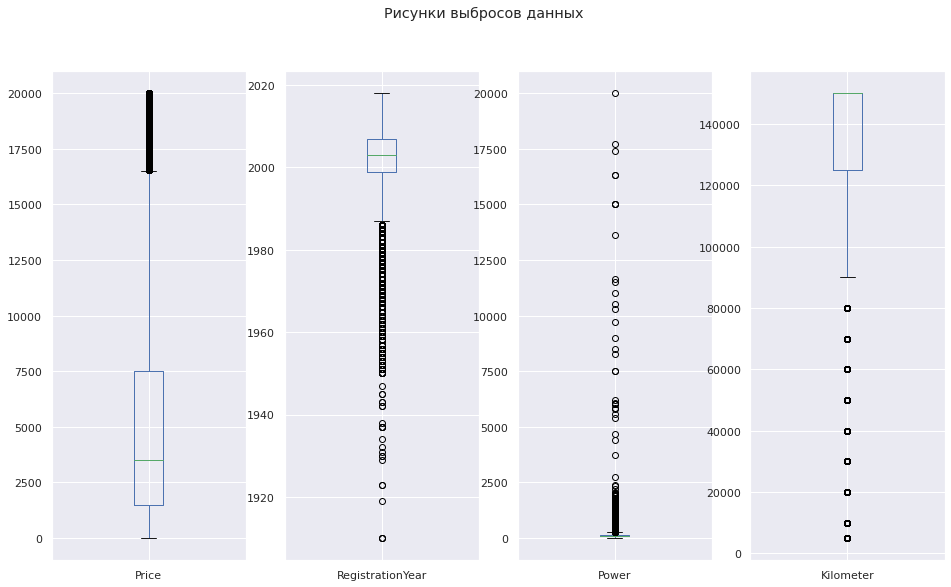

In [ ]:
sns.set()
df.plot(kind = 'box', subplots = True, figsize = (16,9), sharex = False, sharey = False)
plt.suptitle("Рисунки выбросов данных")
plt.show()

In [ ]:
(df['Price'] > 100).value_counts()

True     241465
False      4345
Name: Price, dtype: int64

In [ ]:
(df['RegistrationYear'] > 1979).value_counts()

True     244243
False      1567
Name: RegistrationYear, dtype: int64

In [ ]:
(df['Power'] > 2300).value_counts()

False    245775
True         35
Name: Power, dtype: int64

In [ ]:
df['Kilometer'].value_counts()

150000    159060
125000     27329
100000     11085
90000       9087
80000       8003
70000       6910
60000       6126
50000       5117
40000       4074
30000       3506
20000       2815
5000        1871
10000        827
Name: Kilometer, dtype: int64

**Вывод**

Наблюдаем подозрительные данные по:
- цене автомобилей имеются нулевые цены и очень низкие: 10 евро и подобные. Отфильтруем наблюдения от 100 евро, так как нулевые и низкие цены плохо повлияют на предсказание цены;
- год регистрации автомобиля - имеются данные начала 20 века. Посчитаем, что для качества моделей требуется "свежие" автомобили. Возьмем данные начиная с 1980 года.
- мощность двигателя у легкового автомобиля не может быть более 2200 л.с. (взят самый мощный супер кар). Так же отфильтруем выбросы.

In [ ]:
df = df.loc[df['Price'] > 99]
df = df.loc[df['RegistrationYear'] > 1979]
df = df.loc[df['Power'] < 2300]
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
1,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
2,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
3,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
5,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
...,...,...,...,...,...,...,...,...,...,...
245805,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no
245806,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
245807,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
245808,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no


### Преобразование категориальных признаков в численные техникой прямого кодирования

Преобразуем категориальные признаки в численные техникой прямого кодирования для моделей машинной обучения, которые не работают с числами.

In [ ]:
df_dummies = pd.get_dummies(df, drop_first=True, dummy_na=True)

In [ ]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240245 entries, 0 to 245809
Columns: 310 entries, Price to NotRepaired_nan
dtypes: int64(4), uint8(306)
memory usage: 79.3 MB


Выделим целевой признак и признаки

In [ ]:
y = df_dummies['Price']
X = df_dummies.drop('Price', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    random_state = 42, 
                                                    shuffle = True)
print('\nПроверка деления на выборки\n')
print('Размер X_train:', X_train.shape)
print('Размер X_test:', X_test.shape)
print('Размер y_train:', y_train.shape)
print('Размер y_test:', y_test.shape)


Проверка деления на выборки

Размер X_train: (180183, 309)
Размер X_test: (60062, 309)
Размер y_train: (180183,)
Размер y_test: (60062,)


**Вывод**

- Мы изучили данные
- Удалили пропуски и дубликаты
- Привели категориальные признаки в численные
- Подготовили признаки и целевой признак для обучения моделей.

# 2. Обучение моделей

## Константная модель

Создадим константную модель для возможности проверки последующих моделей на адекватность. 

Предсказание - медиана обучающей выборки.



In [ ]:
# Функция расчета метрики RMSE (root mean squared error)
def make_rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

In [ ]:
# Создадим класс константной модели
class ConstantModel:
    
    def fit(self, y_train):
        self.median = y_train.median()

    def predict(self, X_test):
        return np.ones(len(X_test)) * self.median

# Инициализируем модель
model_const = ConstantModel()

# Обучим модель
start = timeit.default_timer()
model_const.fit(y_train)
stop = timeit.default_timer()

fit_time_const = round(stop - start, 4)
print('Время обучения константной модели: ', fit_time_const)

# Получим предсказания на тестовой выборке
start = timeit.default_timer()
predict_const = model_const.predict(X_test)
stop = timeit.default_timer()

pred_time_const = round(stop - start, 4)
print('Время предсказания константной модели: ', pred_time_const)

# Проверим метрику получившейся модели
rmse_const = round(make_rmse(y_test, predict_const), 2)
print('RMSE константной модели на тестовой выборке:', rmse_const)

# Соберем в список всю информацию по модели
# Зафиксируем время, потребовавшееся для подготовки признаков, перед использованием модели - 0
prep_time = 0.0
lst_const = ['Constant model', prep_time, fit_time_const, pred_time_const, rmse_const]
lst_const

Время обучения константной модели:  0.0029
Время предсказания константной модели:  0.0003
RMSE константной модели на тестовой выборке: 5009.29


['Constant model', 0.0, 0.0029, 0.0003, 5009.29]

## RandomForestRegressor

Подберём гиперпараметры для модели

In [ ]:
%%time
clf = RandomForestRegressor(random_state = 42, n_jobs = -1)

parameter_grid = {'max_depth': [5, 10, 15],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 5],
#  'min_samples_split': [2, 5, 10],
 'n_estimators': [100,200,300,]}

grid_searcher = GridSearchCV(clf, parameter_grid, verbose= True, n_jobs = -1)

grid_searcher.fit(X_train, y_train)

print('Best params = ', grid_searcher.best_estimator_)

Мы будем использовать следующие гиперпараметры.

Best params =  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

CPU times: user 22min 55s, sys: 8.08 s, total: 23min 3s

Wall time: 3h 38min 31s

Обучим модель и сделаем предсказания

In [ ]:
%%time
print('Расчеты на модели случаный лес для регрессии')
model_forest = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
model_forest.fit(X_train, y_train)

Расчеты на модели случаный лес для регрессии
CPU times: user 22min 29s, sys: 2.1 s, total: 22min 31s
Wall time: 11min 25s


In [ ]:
%%time
y_pred = model_forest.predict(X_test)
rmse = make_rmse(y_test, y_pred)
print('rmse на модели RandomForestRegressor:', rmse)

rmse на модели RandomForestRegressor: 1547.351800074839
CPU times: user 3.27 s, sys: 7.88 ms, total: 3.28 s
Wall time: 3.28 s


**Вывод**

Модель RandomForestRegressor на тестовых данных показала следующие показатели:

- Время обучения 11 min 25 s
- Скорость предсказания 3.28 s
- Качество предсказания метрика rmse: 1547

## LinearRegression

Подберём гиперпараметры для модели

In [ ]:
%%time
clf = LinearRegression(n_jobs = -1)

parameter_grid = {"fit_intercept": [True, False],
              "normalize": [True, False],
             }

grid_searcher = GridSearchCV(clf, parameter_grid, verbose= True, n_jobs = -1)

grid_searcher.fit(X_train, y_train)

print('Best params = ', grid_searcher.best_estimator_)

Best params =  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

CPU times: user 9.1 s, sys: 935 ms, total: 10 s

Wall time: 1min 26s

Обучим модель с гиперпараметрами и сделаем предсказания

In [ ]:
%%time
print('Расчеты на модели линейная регрессия')
model_Linear = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
model_Linear.fit(X_train, y_train)

Расчеты на модели линейная регрессия
CPU times: user 8.06 s, sys: 436 ms, total: 8.5 s
Wall time: 4.64 s


In [ ]:
%%time
y_pred = model_Linear.predict(X_test)
rmse = make_rmse(y_test, y_pred)
print('rmse на модели LinearRegression:', rmse)

rmse на модели LinearRegression: 2403.303552229627
CPU times: user 165 ms, sys: 5.01 ms, total: 170 ms
Wall time: 157 ms


**Вывод**

Модель LinearRegression на тестовых данных показала следующие показатели:

- Время обучения 4.64 s
- Скорость предсказания 157 ms
- Качество предсказания метрика rmse: 2403

## LGBMRegressor

Подберем гиперпараметры при помощи GridSearchCV

In [ ]:
%%time
clf = LGBMRegressor(
    random_state = 42, 
    # device = 'gpu'
    )

parameter_grid = {
            'num_leaves': [32, 64],
            'max_depth': [-1, 10, 50],
            'n_estimators': [1000, 3000],
            'learning_rate' : [0.1, 0.01]
                  }
                  

grid_searcher = GridSearchCV(clf, parameter_grid, verbose = 10, n_jobs = -1)
grid_searcher.fit(X_train, y_train,
                  eval_metric = 'rmse',
                  eval_set = (X_test, y_test),
                  early_stopping_rounds = 5,
                  verbose = -1
                  )
 
print('Best params = ', grid_searcher.best_estimator_)

Best params =  LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=64, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

CPU times: user 34.7 s, sys: 3.31 s, total: 38 s

Wall time: 43min 29s

Обучим модель с подобранными гиперпараметрами.

In [ ]:
%%time
model_LGBM = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=64, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
model_LGBM.fit(X_train, y_train)

CPU times: user 22.6 s, sys: 291 ms, total: 22.9 s
Wall time: 12.6 s


In [ ]:
%%time
predicted_test = model_LGBM.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predicted_test))
print('RMSE:', rmse)

RMSE: 1473.8457640948855
CPU times: user 7.1 s, sys: 30.9 ms, total: 7.13 s
Wall time: 3.73 s


**Вывод**

Модель LGBMRegressor на тестовых данных показала следующие показатели:
- Качество предсказания метрика rmse: 1474
- Время обучения 10.3 s
- Скорость предсказания 3.2 s

## XGBoostRegressor

Подберем гиперпараметры

In [ ]:
%%time
# Various hyper-parameters to tune
clf = XGBRegressor(tree_method='gpu_hist', gpu_id=0, n_jobs= -1, random_state=42)

parameter_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.03, 0.05, 0.07], #so called `eta` value
              'max_depth': [-1, 5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]
              }

kf = KFold(n_splits = 5, random_state = 42)

grid_searcher = GridSearchCV(clf, parameter_grid, verbose = True, cv = kf, n_jobs= -1)
grid_searcher.fit(X_train, y_train)
# clf_best = grid_searcher.best_estimator_

print('Best score = ', grid_searcher.best_score_) 
print('Best parameters = ', grid_searcher.best_estimator_)

Best score =  0.888448966593732
Best parameters =  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=7, min_child_weight=4, missing=None, n_estimators=500,
             n_jobs=-1, nthread=4, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, tree_method='gpu_hist', verbosity=1)

CPU times: user 13.2 s, sys: 1.07 s, total: 14.3 s

Wall time: 5min 57s

Обучим модель с подобранными гиперпараметрами и сделаем предсказание

In [ ]:
%%time
model_XGBoost = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=7, min_child_weight=4, missing=None, n_estimators=500,
             n_jobs=-1, nthread=4, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, tree_method='gpu_hist', verbosity=1)
model_XGBoost.fit(X_train, y_train)

CPU times: user 11.7 s, sys: 603 ms, total: 12.3 s
Wall time: 12.3 s


In [ ]:
%%time
y_pred = model_XGBoost.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('rmse:', rmse)

rmse: 1572.4511771960454
CPU times: user 967 ms, sys: 2.37 ms, total: 970 ms
Wall time: 966 ms


**Вывод**

Модель XGBoostRegressor на тестовых данных показала следующие показатели:
- Качество предсказания метрика rmse: 1524
- Время обучения 11.6 s
- Скорость предсказания 1 s

## CatBoostRegressor

Подготовим признаки для модели CatBoost, которая умеет работать с категориальными признаками.

In [ ]:
y = df['Price']
X = df.drop('Price', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25,
                                                    random_state = 42, 
                                                    shuffle = True)
print('Проверка деления на выборки')
print('Размер X_train:', X_train.shape)
print('Размер X_test:', X_test.shape)
print('Размер y_train:', y_train.shape)
print('Размер y_test:', y_test.shape)

Проверка деления на выборки
Размер X_train: (180183, 9)
Размер X_test: (60062, 9)
Размер y_train: (180183,)
Размер y_test: (60062,)


In [ ]:
cat_features = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired']

Мы будем использовать видеокарту для ускорения процесса подбора гиперпараметров и обучения модели.

In [ ]:
%%time
clf = CatBoostRegressor(
                        task_type= 'GPU',
                        cat_features = cat_features, 
                        random_state = 42, 
                        early_stopping_rounds = 5
                        )

parameter_grid = {
            'max_depth' : [1, 8, 16],
            'n_estimators' : [1000, 3000, 5000],
            'learning_rate' : [0.1, 0.01, 0.001]
        }

kf = KFold(n_splits = 5, random_state = 42)

grid_searcher = GridSearchCV(clf, parameter_grid, verbose = 100, n_jobs = -1, cv = kf)
grid_searcher.fit(X_train, y_train)
 
print('Best params = ', grid_searcher.best_estimator_)

Best params =  {'learning_rate': 0.1, 'loss_function': 'RMSE', 'task_type': 'GPU', 'max_depth': 8, 'n_estimators': 3000, 'random_state': 42, 'early_stopping_rounds': 5, 'cat_features': ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired']}


CPU times: user 2min 40s, sys: 2min 38s, total: 5min 19s

Wall time: 2h 41min 13s

Обучим модель с подобранными гиперпараметрами и сделаем предсказание

In [ ]:
%%time
model_CatBoost = CatBoostRegressor(cat_features = cat_features, 
                                   max_depth = 8, 
                                   n_estimators = 3000, 
                                   verbose = 0,
                                   task_type= 'GPU',
                                   random_state = 42,
                                   learning_rate = 0.1)
model_CatBoost.fit(X_train, y_train)

CPU times: user 56.7 s, sys: 14.3 s, total: 1min 11s
Wall time: 51.5 s


In [ ]:
%%time
predicted_test = model_CatBoost.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predicted_test))
print('RMSE:', rmse)

RMSE: 2636.136108010434
CPU times: user 1.31 s, sys: 193 ms, total: 1.5 s
Wall time: 781 ms


**Вывод**

Модель CatBoostRegressor на тестовых данных показала следующие показатели:
- Качество предсказания метрика rmse: 2484
- Время обучения 1 min 47s
- Скорость предсказания 666 ms

# 3. Анализ моделей

Сведем в таблицу данные о моделях

<table>
    <tr><th>Показатель / Модель</th><th>LGBMRegressor</th><th>CatBoostRegressor</th><th>XGBoostRegressor</th><th>RandomForestRegressor</th><th>LinearRegression</th></tr>
    <tr><td>Качество предсказания метрика rmse</td><td>1474</td><td>2484</td><td>1524</td><td>1547</td><td>2403</td></tr>
    <tr><td>Скорость предсказания</td><td>3.2 s</td><td>666 ms</td><td>1 s</td><td>3.28 s</td><td>157 ms</td></tr>
    <tr><td>Время обучения</td><td>10.3 s</td><td>1 min 47 s</td><td>11.6 s</td><td>11 min 25s</td><td>4.64 s</td></tr>
</table>

**Вывод**

По задаче Заказчику важны: качество предсказания; скорость предсказания; время обучения.

По всем трём показателям лучше всего подходит модель LGBMRegressor. Она быстро обучается и дает лучшее качество.